Contracts

In [1]:
from pacti.contracts import PolyhedralIoContract

#P - population
K = 100 #carrying capacity

contract_logistic = PolyhedralIoContract.from_strings(
    input_vars = ["t"],
    output_vars = ["P"],
    assumptions = [],
    guarantees = ["P >= 0", f"P <= {K}"]
)
print(contract_logistic)


#H - conserved quantity of the system
# values came from a specific system 
H0 = 6.95 #initial H value
x_max = 6.82 #max prey population
y_max = 7.78 #max predator population
epsilon = 1e-3 #tolerance level

contract_lotka_volterra = PolyhedralIoContract.from_strings(
    input_vars = [],
    output_vars = ["x", "y", "H"],
    assumptions = [],
    guarantees = ["x >= 0",
                  "y >= 0",
                  f"x <= {x_max}",
                  f"y <= {y_max}",
                  f"H >= {H0 - epsilon}",
                  f"H<= {H0 + epsilon}"
                  ]
)
print(contract_lotka_volterra)

InVars: [t]
OutVars:[P]
A: [
  
]
G: [
  -P <= 0
  P <= 100
]
InVars: []
OutVars:[x, y, H]
A: [
  
]
G: [
  -x <= 0
  -y <= 0
  x <= 6.82
  y <= 7.78
  -H <= -6.949
  H <= 6.951
]


Plot Logistic Growth Contract

Text(0.5, 1.0, 'Logistic Growth Contract')

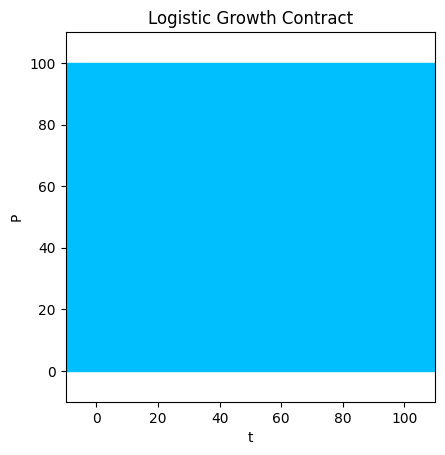

In [2]:
import matplotlib.pyplot as plt
from pacti.utils.plots import plot_assumptions, plot_guarantees
from pacti.iocontract import Var

plot_guarantees(
    contract=contract_logistic,
    x_var=Var("t"),       
    y_var=Var("P"),
    var_values={},       
    x_lims=(-10, 110),
    y_lims=(-10, 110)
)
plt.title("Logistic Growth Contract")

Lotka-Volterra Contract Plots

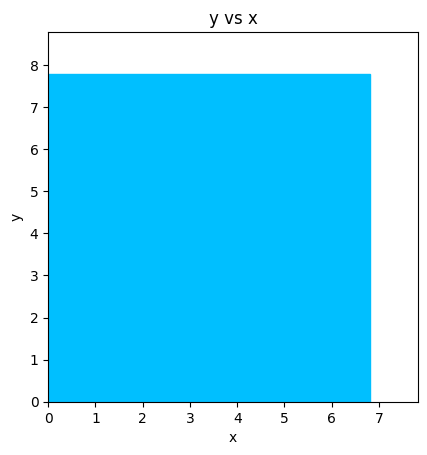

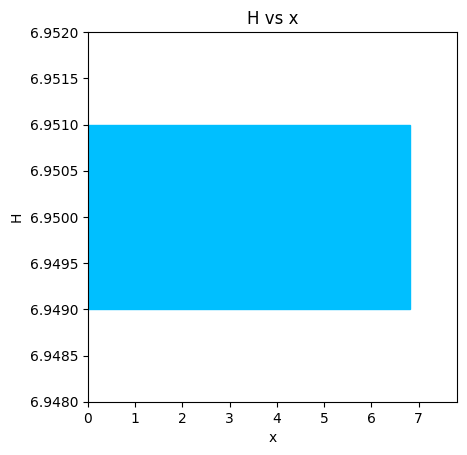

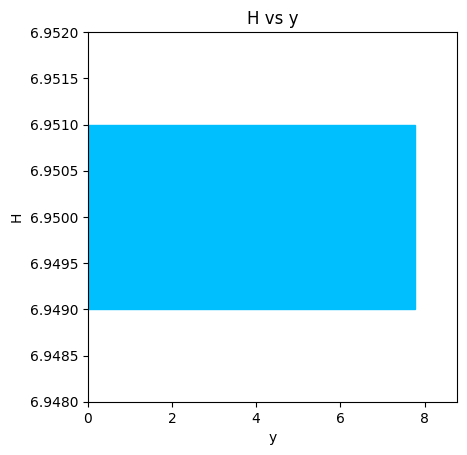

In [3]:
plot_guarantees(
    contract=contract_lotka_volterra,
    x_var=Var("x"),
    y_var=Var("y"),
    var_values={Var("H"): H0}, 
    x_lims=(0, x_max + 1),
    y_lims=(0, y_max + 1)
)
plt.title("y vs x")

plot_guarantees(
    contract=contract_lotka_volterra,
    x_var=Var("x"),
    y_var=Var("H"),
    var_values={Var("y"): y_max},
    x_lims=(0, x_max + 1),
    y_lims=(H0 - 2*epsilon, H0 + 2*epsilon)
)
plt.title("H vs x")

plot_guarantees(
    contract=contract_lotka_volterra,
    x_var=Var("y"),
    y_var=Var("H"),
    var_values={Var("x"): x_max},
    x_lims=(0, y_max + 1),
    y_lims=(H0 - 2*epsilon, H0 + 2*epsilon)
)
plt.title("H vs y")
plt.show()

Check LV

The lotka-volterra predator-prey model is not a valid implementation of logistic growth
Total samples: 500
x (prey) violated logistic region in 497 cases
y (predator) violated logistic region in 491 cases


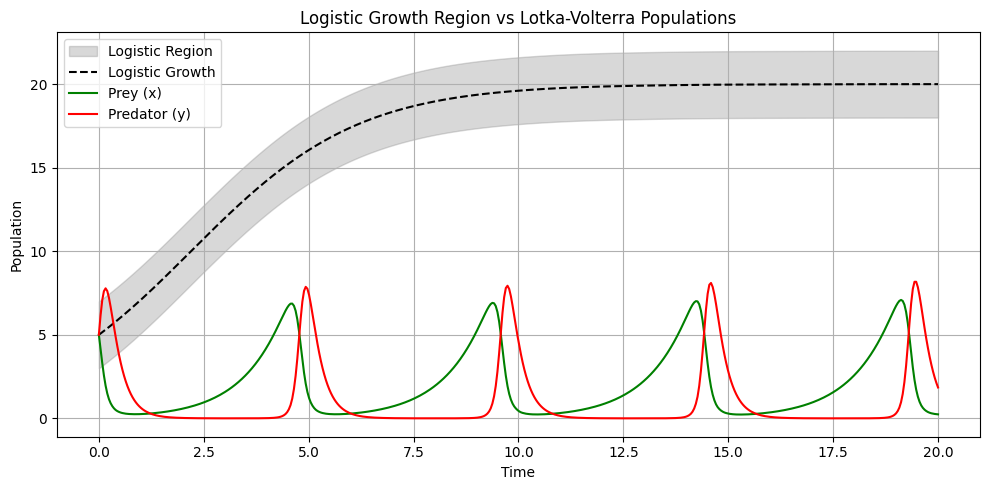

In [4]:
import numpy as np
from scipy.integrate import solve_ivp

#logistic growth equation dP/dt = r*P *(1-P/K)
def logistic_growth(t, P, r, K):
    return r * P * (1 - P / K)
#parameters
K = 20 #carrying capacity
r = 0.5 #growth rate
P0 = 5 #initial population

#lv system of equations
def lotka_volterra(t, population, alpha, beta, gamma, delta):
    x, y = population 
    dxdt = (alpha * x) - (beta * x * y)
    dydt = (-gamma * y) + (delta * x * y)
    return dxdt, dydt    
#parameters
alpha = 1 #prey birth rate
beta = 1 #prey death rate due to predation
gamma = 4 #predator death rate
delta = 2 #predator birth rate
x0_y0 = (5, 5) #initial predator and prey populations

time_range = (0, 20) #0 to 20 seconds
t_vals = np.linspace(*time_range, 500) #500 different times

#solve logistic
sol_logistic = solve_ivp(logistic_growth, time_range, [P0], args=(r, K), t_eval=t_vals)
P_vals = sol_logistic.y[0]
#solve LV
sol_lv = solve_ivp(lotka_volterra, time_range, x0_y0, args=(alpha, beta, gamma, delta), t_eval=t_vals)
x_vals = sol_lv.y[0]
y_vals = sol_lv.y[1]

region = 2
x_violations = 0
y_violations = 0

#check if each point satisfies contract
for t_val, P_val, x_val, y_val in zip(t_vals, P_vals, x_vals, y_vals):
    #bounds of logistic region
    P_lower = P_val - region
    P_upper = P_val + region

    contract = PolyhedralIoContract.from_strings(
        input_vars=["t"],
        output_vars=["P"],
        assumptions=["t >= 0"],
        guarantees=[f"P >= {P_lower}",f"P <= {P_upper}"]
    )

    behavior_x = {Var("t"): t_val, Var("P"): x_val}
    behavior_y = {Var("t"): t_val, Var("P"): y_val}

    if not contract.a.contains_behavior(behavior_x) or not contract.g.contains_behavior(behavior_x):
        x_violations += 1

    if not contract.a.contains_behavior(behavior_y) or not contract.g.contains_behavior(behavior_y):
        y_violations += 1

#print results
if x_violations > 0 or y_violations > 0:
    print("The lotka-volterra predator-prey model is not a valid implementation of logistic growth")
else:
    print("The lotka-volterra predator-prey model is a valid implementation of logistic growth")
print(f"Total samples: {len(t_vals)}")
print(f"x (prey) violated logistic region in {x_violations} cases")
print(f"y (predator) violated logistic region in {y_violations} cases")


#logistic growth region
P_lower = P_vals - region
P_upper = P_vals + region

# plot 
plt.figure(figsize=(10, 5))

#logistic region
plt.fill_between(t_vals, P_lower, P_upper, color='gray', alpha=0.3, label='Logistic Region')

#logistic and lv curves
plt.plot(t_vals, P_vals, label="Logistic Growth", color='black', linestyle='--')
plt.plot(t_vals, x_vals, label="Prey (x)", color='green')
plt.plot(t_vals, y_vals, label="Predator (y)", color='red')

plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Logistic Growth Region vs Lotka-Volterra Populations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Check Piecewise function

The piecewise function is a valid implementation of logistic growth
Total samples: 500
The piecewise function violated the logistic region in 0 cases


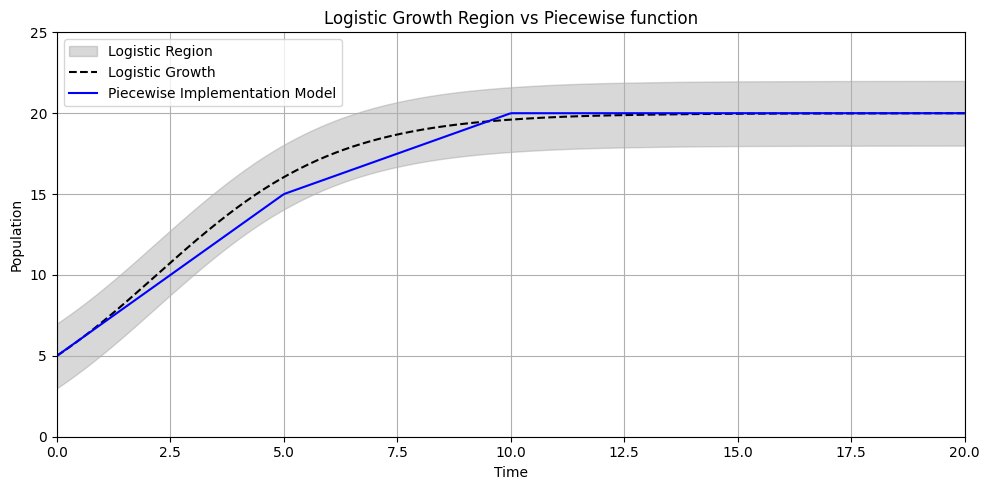

In [5]:
'''
import numpy as np
from scipy.integrate import solve_ivp

#logistic growth equation dP/dt = r*P *(1-P/K)
def logistic_growth(t, P, r, K):
    return r * P * (1 - P / K)
#parameters
K = 20 #carrying capacity
r = 0.5 #growth rate
P0 = 5 #initial population

time_range = (0, 20) #0 to 20 seconds
t_vals = np.linspace(*time_range, 500) #500 different times
'''

#piecewise function implementation
def piecewise_implementation_model(t):
    if t < 5:
        return 2*t + 5
    elif t < 10:
        return t + 10 
    else:
        return 20

#values of function for given times
f_vals = np.array([piecewise_implementation_model(t) for t in t_vals])

'''
#solve logistic
sol_logistic = solve_ivp(logistic_growth, time_range, [P0], args=(r, K), t_eval=t_vals)
P_vals = sol_logistic.y[0]
'''

region = 2
violations = 0

#check if each point satisfies contract
for t_val, P_val, f_val in zip(t_vals, P_vals, f_vals):
    #bounds of region
    P_lower = P_val - region
    P_upper = P_val + region

    contract = PolyhedralIoContract.from_strings(
        input_vars=["t"],
        output_vars=["P"],
        assumptions=["t >= 0"],
        guarantees=[f"P >= {P_lower}",f"P <= {P_upper}"]
    )

    behavior_f = {Var("t"): t_val, Var("P"): f_val}

    if not contract.a.contains_behavior(behavior_f) or not contract.g.contains_behavior(behavior_f):
        violations += 1

#print results
if violations > 0:
    print("The piecewise function is not a valid implementation of logistic growth")
else:
    print("The piecewise function is a valid implementation of logistic growth")
print(f"Total samples: {len(t_vals)}")
print(f"The piecewise function violated the logistic region in {violations} cases")

#logistic growth region
P_lower = P_vals - region
P_upper = P_vals + region

#plot 
plt.figure(figsize=(10, 5))

#fill logistic region
plt.fill_between(t_vals, P_lower, P_upper, color='gray', alpha=0.3, label='Logistic Region')

#logistic curve
plt.plot(t_vals, P_vals, label="Logistic Growth", color='black', linestyle='--')
#piecewise curve 
plt.plot(t_vals, f_vals, label="Piecewise Implementation Model", color='blue')

plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Logistic Growth Region vs Piecewise function")

plt.xlim(0, 20)
plt.ylim(0, 25)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()